In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI as prop
from CoolProp.CoolProp import PhaseSI as phase



In [2]:
#############################################
### Correlations and functions definition ###
#############################################

def f_chur(Re,D):
    
    rug = 0.0046e-2 #Rugosidade para o alumínio em m
    A = (2.457*np.log(1/((7/Re)**0.9+0.27*(rug/D))))**16
    B = (37530/Re)**16
    parameter = 8*((8/Re)**12 + (A+B)**(-3/2))**(1/12)
    
    return(parameter)

def dpdz_mull_heck(x,G,D,f_l,rho_l,f_v,rho_v):
    
    dpdz_lo = f_l*G**2/(2*D*rho_l)
    dpdz_vo = f_v*G**2/(2*D*rho_v)
    A = dpdz_lo+2*(dpdz_vo-dpdz_lo)*x
    parameter = A*(1-x)**(1/3) + dpdz_vo*x**3
    
    return(parameter)

def Xtt(x,G,D,f_l,rho_l,f_v,rho_v):
    
    dpdz_l = 2*f_l*G**2*(1-x)**2/(D*rho_l)
    dpdz_v = 2*f_v*G**2*x**2/(D*rho_v)
    parameter = math.sqrt(dpdz_l/dpdz_v)
    
    return(parameter)


def  eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,D):
    
    Nu_lo = Re_lo**(4/5)*Pr_lo**0.4
    eta_lo = Nu_lo*k_lo/D
    parameter = eta_lo*3.3775*xtt**-0.6285
    
    return(parameter)

def  eta_mono(Re,Pr,k,D):
    
    Nu = 0.023*Re**(4/5)*Pr**(1/3)
    parameter = Nu*k/D

    return(parameter)

def eta_air(Re_air,Pr_air,G_air,cp_air,Ap,Af):
    
    eps= (Ap+Af)/Ap
    j = 0.138*Re_air**(-0.281)*eps**(-0.407)
    St = j*Pr_air**(-2/3)
    parameter = St*G_air*cp_air
    
    return(parameter)

def surf_eff(Ap,Af,D_in,delta,eta_ar,k_al,x_t,x_l):
    
    r=D_in/2
    M=x_t
    L=math.sqrt((x_t/2)**2+x_l**2)    
    phi=L/M
    psi=M/r
    R_eq = r*1.27*psi*(phi-0.3)**(1/2)
    
    m=math.sqrt(2*eta_ar/(k_al*delta))
    var_phi = (R_eq/r -1)*(1+0.35*np.log(R_eq/r))
    eff_fin=np.tanh(m*r*var_phi)/(m*r*var_phi)
    parameter = 1-(1-eff_fin)*(Af/(Ap+Af))
    
    return(parameter)
    
def epsilon(C_ar,C_r134a,NTU,quality_r134a):
    
    if quality_r134a < 1:
        
        parameter = 1 - np.exp(-NTU)
    
    elif quality_r134a == 1: 
        
        if C_ar >= C_r134a:
        
            c = C_r134a/C_ar
            parameter = 1 - np.exp(-(1/c)*(1-np.exp(-c*NTU)))

            
        if C_ar < C_r134a:
            
            c = C_ar/C_r134a
            parameter = (1/c)*(1-np.exp(1-c*(1-np.exp(-NTU))))
    
    return(parameter)

def NUT(C_ar,C_r134a,eps,quality_r134a):
    
    if quality_r134a < 1:
        
        parameter = - np.log(1 - eps)
    
    elif quality_r134a == 1: 
        
        if C_ar >= C_r134a:
        
            c = C_r134a/C_ar
            parameter = - np.log(c*np.log(1-eps)+1)/c
            
        if C_ar < C_r134a:
            
            c = C_ar/C_r134a
            parameter = - np.log(1 + np.log(1-eps*c)/c)
    
    return(parameter)


In [3]:
###############################
### Equações de conservação ###
###############################

def movimento(Pin,W,Di,G,v,mu_l):
    
    Re = G*Di/mu_l
    f = f_chur(Re,Di)
    tau = f*G**2*v/8
    parameter = Pin - tau*np.pi*W*4/(np.pi*Di)
    
    return(parameter)

def movimento_dryout(Pin,Pout,Di,G,v,mu_l):
    
    Re = G*Di/mu_l
    f = f_chur(Re,Di)
    tau = f*G**2*v/8
    parameter = -(Pout - Pin)*np.pi*Di/(tau*np.pi*4)
    
    return(parameter)

def energia_bi(hin,Pin,Pavg,Qavg,mfrin,Tain,Taavg,Pa,mfra,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl,Do):
    
    mu_l =prop('V','P',Pavg,'Q',0,'R134a')
    mu_v = prop('V','P',Pavg,'Q',1,'R134a')
    rho_l = prop('D','P',Pavg,'Q',0,'R134a')
    rho_v = prop('D','P',Pavg,'Q',1,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    G_l = G*(1-Qavg)
    G_v = G*Qavg
    Re_l = G_l*Di/mu_l
    Re_v = G_v*Di/mu_v
    f_l =f_chur(Re_l,Di)
    f_v =f_chur(Re_v,Di)
    
    xtt = Xtt(Qavg,G,Di,f_l,rho_l,f_v,rho_v)
    Re_lo = G*Di/prop('V','P',Pavg,'Q',0,'R134a')
    Pr_lo = prop('PRANDTL','P',Pavg,'Q',0,'R134a')
    k_lo = prop('L','P',Pavg,'Q',0,'R134a')
    
    etabi=eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,Di)
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('V','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    #mfr_a = rho_a*vfrin
    G_a= (mfra/A_c)
    Re_a = G_a*Do/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s)
     
    eff_surf = surf_eff(A_p,A_s,Do,deltaf,eta_a,kal,xt,xl)
    
        
    C_a = mfra*cp_a
    cp_r=prop('C','P',Pavg,'Q',Qavg,'R134a')
    C_r = mfrin*cp_r
    #Ph = phase('P',Pavg,'Q',Qavg,'R134a')
    UA = (1/(etabi*np.pi*Di*W) + 9/(eff_surf*eta_a*A_t))**-1
    #print((etabi*np.pi*Di*W),(eff_surf*eta_a*A_t))
    Ntu = UA/C_a
    #print(eta_a,eff_surf,A_t)
    
    eff = epsilon(C_a,C_r,Ntu,Qavg)
 
    parameter2 = eff*C_a*(Tain-Tin)
    parameter = hin + parameter2*4/(G*np.pi*Di**2)
    
    return(parameter,parameter2)


def energia_mono(hin,Pin,Pavg,havg,mfrin,Tain,Taavg,Pa,mfra,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl,Do):
    
    mu_v = prop('V','P',Pavg,'H',havg,'R134a')
    rho_v = prop('D','P',Pavg,'H',havg,'R134a')
    Pr_v = prop('PRANDTL','P',Pavg,'H',havg,'R134a')
    k_v = prop('L','P',Pavg,'H',havg,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    Re_v = G*Di/mu_v
    f_v =f_chur(Re_v,Di)
   
    etamono=eta_mono(Re_v,Pr_v,k_v,Di)
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('V','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    #mfr_a = rho_a*vfrin
    G_a= (mfra/A_c)
    Re_a = G_a*Do/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s)
    eff_surf = surf_eff(A_p,A_s,Di,deltaf,eta_a,kal,xt,xl)

    C_a = mfra*cp_a
    cp_v=prop('C','P',Pavg,'H',havg,'R134a')
    C_v = mfrin*cp_v
    #Ph = phase('P',Pavg,'Q',Qavg,'R134a')

    UA = (1/(etamono*np.pi*Di*W) + 1/(eff_surf*eta_a*A_t))**-1
    Ntu = UA/min(C_a,C_v)
    
    
    eff = epsilon(C_a,C_v,Ntu,1)
    parameter2 = eff*min(C_a,C_v)*(Tain-Tin)
    parameter = hin + parameter2*4/(G*np.pi*Di**2)
    
    return(parameter,parameter2)

def energia_dryout(hin,Q_ht_bif,Pin,Pavg,Qavg,mfrin,Tain,Taavg,Pa,mfra,L,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl):
    
    Qin = prop('Q','P',Pin,'H',hin,'R134a')
    #hsat = prop('H','P',Pavg,'Q',1,'R134a')
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    #rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('D','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    #C_a = mfra*cp_a
    #cp_r=prop('C','P',Pavg,'Q',Qavg,'R134a')    
    #C_r = mfrin*cp_r
    
    mu_l =prop('V','P',Pavg,'Q',0,'R134a')
    mu_v = prop('V','P',Pavg,'Q',1,'R134a')
    rho_l = prop('D','P',Pavg,'Q',0,'R134a')
    rho_v = prop('D','P',Pavg,'Q',1,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    G_l = G*(1-Qavg)
    G_v = G*Qavg
    Re_l = G_l*Di/mu_l
    Re_v = G_v*Di/mu_v
    f_l =f_chur(Re_l,Di)
    f_v =f_chur(Re_v,Di)
    
    xtt = Xtt(Qavg,G,Di,f_l,rho_l,f_v,rho_v)
    Re_lo = G*Di/prop('V','P',Pavg,'Q',0,'R134a')
    Pr_lo = prop('PRANDTL','P',Pavg,'Q',0,'R134a')
    k_lo = prop('L','P',Pavg,'Q',0,'R134a')
    
    etabi=eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,Di)

    #mfr_a = rho_a*vfrin
    G_a= (mfra/A_c)
    Re_a = G_a*D_o/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s)
    eff_surf = surf_eff(A_p,A_s,Di,deltaf,eta_a,kal,xt,xl)
    
    
    #U = (1/(etabi*np.pi*Di*L) + 1/(eff_surf*eta_a))**-1
    U = (1/etabi + 1/(eff_surf*eta_a))**-1
    
    parameter = Q_ht_bif/(U*(Taavg-Tin))
    
    return(parameter)

def wall_temp(Travg,eta_r,Di,W,Taavg,eta_a,A_t):
    
    parameter=(Travg*eta_r*np.pi*Di*W + Taavg*eta_a*A_t)/(eta_r*np.pi*Di*W + eta_a*A_t)
    
    return(parameter)

def energia_ar(Tain,Taavg,Pa,mfra,Q_ht):
    
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    parameter = Tain - Q_ht/(mfra*cp_a)
    
    return(parameter)


    

In [4]:
################
### Geometry ###
################

W=300e-3
L = 190e-3
H=60e-3
nt_l = 10
nt_v = 2
delta_f = 0.15e-3
x_t = 11e-3
x_l = 19e-3
D_i = 6.7e-3
D_o=7.9e-3
L_t=W

# Region I

nf_I = 23
nt_I = 6
L_I = 3*x_l
Ap_I = np.pi*D_o*(W-nf_I*delta_f)*nt_I+2*(L_I*H - np.pi*D_o**2/4*nt_I)
#As_I = 2*(L_I*H - np.pi*D_o**2/4*nt_I)*(nf_I+1)+H*delta_f*nf_I
As_I = 2*(L_I*H - np.pi*D_o**2/4*nt_I)*(nf_I)+H*delta_f*nf_I
At_I = Ap_I+As_I

two_a_I = (x_t - D_o) - (x_t-D_o)*delta_f*nf_I/W
b_I = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_I/W

c_I = min(two_a_I,2*b_I)

Ac_I = (H/x_t-1)*c_I*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_I 

# Region II

nf_II = 47
nt_II = 4
L_II = 3*x_l
Ap_II = np.pi*D_o*(W-nf_II*delta_f)*nt_II+2*(L_II*H - np.pi*D_o**2/4*nt_II)
#As_II = 2*(L_II*H - np.pi*D_o**2/4*nt_II)*(nf_II+1)
As_II = 2*(L_II*H - np.pi*D_o**2/4*nt_II)*(nf_II)
At_II = Ap_II+As_II

two_a_II = (x_t - D_o) - (x_t-D_o)*delta_f*nf_II/W
b_II = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_II/W

c_II = min(two_a_II,2*b_II)

Ac_II = (H/x_t-1)*c_II*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_II

# Region III

nf_III = 47
nt_III = 10
L_III = 4*x_l
Ap_III = np.pi*D_o*(W-nf_III*delta_f)*nt_III+2*(L_III*H - np.pi*D_o**2/4*nt_III)
#As_III = 2*(L_III*H - np.pi*D_o**2/4*nt_III)*(nf_III+1)+H*delta_f*nf_III
As_III = 2*(L_III*H - np.pi*D_o**2/4*nt_III)*(nf_III)+H*delta_f*nf_III
At_III = Ap_III+As_III

two_a_III = (x_t - D_o) - (x_t-D_o)*delta_f*nf_III/W
b_III = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_III/W

c_III = min(two_a_III,2*b_III)

Ac_III = (H/x_t-1)*c_III*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_III

In [5]:
###############
### Circuit ###
###############

#index function
def j_index(value,jcircuit):
    
    ind_1, ind_2 = np.where(jcircuit == value)

    return(ind_1,ind_2)

#ccorrente e paralelo
j_circuit=np.zeros((10,2))

for k in range(2):
  
    for j in range(10):
        
        if k == 0:
            j_circuit[j][k] = 9-j
        else:
            j_circuit[j][k] = 9+1+j

# ccorrente

'''j_circuit=np.zeros((10,2))
  
for j in range(10):

    for k in range(2):
        
        if j % 2 == 0:
            j_circuit[j][0] = (9-j)*(2)+1
            j_circuit[j][1] = (9-j)*(2)
        else:
            j_circuit[j][0] = (9-j)*(2)
            j_circuit[j][1] = (9-j)*(2)+1'''
            
'''# paralelo

j_circuit=np.zeros((10,2))
  
for j in range(10):

    for k in range(2):
        
        if j % 2 == 0:
            j_circuit[j][0] = (j)*(2)+1
            j_circuit[j][1] = (j)*(2)
        else:
            j_circuit[j][0] = (j)*(2)
            j_circuit[j][1] = (j)*(2)+1'''

'# paralelo\n\nj_circuit=np.zeros((10,2))\n  \nfor j in range(10):\n\n    for k in range(2):\n        \n        if j % 2 == 0:\n            j_circuit[j][0] = (j)*(2)+1\n            j_circuit[j][1] = (j)*(2)\n        else:\n            j_circuit[j][0] = (j)*(2)\n            j_circuit[j][1] = (j)*(2)+1'

In [11]:
##############################
### Inputs and first guess ###
##############################

#Test 1
'''Pr_inlet = 0.779e5
Q_inlet = 0.427
Ta_inlet = -20.7+273.15
mfrr_inlet = 3.2/3600
vfra_inlet = 50.5/3600'''

#Test 2
'''Pr_inlet = 0.795e5
Q_inlet = 0.43
Ta_inlet = -11.4+273.15#
mfrr_inlet = 2.6/3600#2.6/3600
vfra_inlet = 50.8/3600#50.8/3600'''

#Test 3
'''Pr_inlet = 0.785e5
Q_inlet = 0.43
Ta_inlet = -14.8+273.15#
mfrr_inlet = 2.8/3600
vfra_inlet = 49.3/3600'''

#test resultados

Q_inlet = 0.34
Pr_inlet = prop('P','T',-31+273.15,'Q',Q_inlet,'R134a')
Ta_inlet = -15+273.15#
mfrr_inlet = 3.5/3600
vfra_inlet = 50/3600


Tr_inlet = prop('T','P',Pr_inlet,'Q',Q_inlet,'R134a')
hr_inlet = prop('H','P',Pr_inlet,'Q',Q_inlet,'R134a')
hr_outlet = prop('H','P',Pr_inlet,'Q',1,'R134a')
G_r = mfrr_inlet/(np.pi*D_i**2/4)
Pa_inlet = 101325
rhoa_inlet = prop('D','P',Pa_inlet,'T',Ta_inlet,'Air')
mfra_inlet = rhoa_inlet*vfra_inlet
k_al = 203


hr_in = np.linspace(hr_inlet,hr_outlet,20)#np.ones((20))*hr_inlet 
hr_out = np.linspace(hr_inlet,hr_outlet,20)#np.ones((20))*hr_inlet

Tref_in=np.zeros((20))
Tref_out=np.zeros((20))
Pr_in=np.ones((20))*Pr_inlet
Pr_out=np.ones((20))*Pr_inlet
Qr_in=np.ones((20))*Q_inlet
Qr_out=np.ones((20))*Q_inlet
#Qr_in[0]=Q_inlet
Q_ht_r=np.zeros((20))
eta_r=np.zeros((20))
eta_airside=np.zeros((20))
Ta_in=np.ones((10,2))*(Tr_inlet)
Ta_out=np.ones((10,2))*(Tr_inlet)
#Ta_in[:,0]=np.linspace(Ta_inlet,Tr_inlet,10)#np.ones((10))*(Tr_inlet)
#Ta_in[:,1]=np.linspace(Ta_inlet,Tr_inlet,10)#np.ones((10))*(Tr_inlet)
#Ta_out[:,0]=np.linspace(Ta_inlet,Tr_inlet,10)#np.ones((10))*(Tr_inlet)
#Ta_out[:,1]=np.linspace(Ta_inlet,Tr_inlet,10)#np.ones((10))*(Tr_inlet)
Ta_in[0,:]=Ta_inlet

hr_out_cycle = np.zeros((20))
Pr_out_cycle = np.zeros((20))
Ta_out_cycle = np.zeros((10,2))
hr_out_cycle_new = np.zeros((20))
Pr_out_cycle_new = np.zeros((20))
Ta_out_cycle_new = np.zeros((10,2))

Ap=np.zeros((10,2))
As=np.zeros((10,2))
At=np.zeros((10,2))
Ac=np.zeros((10,2))

Ap[0:4,:]=Ap_I
Ap[4:7,:]=Ap_II
Ap[7:10,:]=Ap_III

As[0:4,:]=As_I
As[4:7,:]=As_II
As[7:10,:]=As_III

Ac[0:4,:]=Ac_I
Ac[4:7,:]=Ac_II
Ac[7:10,:]=Ac_III

At[0:4,:]=Ap_I+As_I
At[4:7,:]=Ap_II+As_III
At[7:10,:]=Ap_III+As_III


In [12]:
####################
### Main Routine ###
####################

tube_it=1000000000
air_it=10000000000
cycle_it=100000000
dry_it = 100000000

alpha_tube_nodryout = 0
alpha_air = 0
alpha_cycle = 0
alpha_dry = 0

Tol_cycle = 1e-4
Tol_air = 1e-2
Tol_tube = 1e-2
tol_dryout = 1e-2

n_dry = 5

T_air_row =[0,0]

for res in range(cycle_it):
    
    hr_out_cycle_old = np.copy(hr_out)
    Pr_out_cycle_old = np.copy(Pr_out)
    Ta_out_cycle_old = np.copy(Ta_out)
    

    ############
    ### Tube ###
    ############
    
    for ind in range(20):

        ind_j,ind_k = j_index(ind,j_circuit)
        Ta_in_tube = Ta_in[int(ind_j),int(ind_k)]
        Ta_out_tube = Ta_out_cycle_old[int(ind_j),int(ind_k)]
        Ta_avg = (Ta_in_tube+Ta_out_tube)/2 
        Tr_in = prop('T','P',Pr_in[ind],'H',hr_in[ind],'R134a')        
        Q_in = abs(prop('Q','P',Pr_in[ind],'H',hr_in[ind],'R134a'))
        #Q_out = abs(prop('Q','P',Pr_out_cycle_old[ind],'H',hr_out_cycle_old[ind],'R134a'))
        Pr_out_old_it = float(np.copy(Pr_out_cycle_old[ind]))
        hr_out_old_it = float(np.copy(hr_out_cycle_old[ind]))
        Q_out = abs(prop('Q','P',Pr_out_old_it,'H',hr_out_old_it,'R134a'))

        for res in range(tube_it):
            
            Pr_out_old = Pr_out_old_it
            hr_out_old = hr_out_old_it
            Pr_avg = (Pr_in[ind]+Pr_out_old)/2
            hr_avg = (hr_in[ind]+hr_out_old)/2
            Q_avg = (Q_in+Q_out)/2

            rho_r = prop('D','P',Pr_in[ind],'H',hr_in[ind],'R134a')
            v_r = 1/rho_r
            
            if Q_in < 1 and Q_out < 1 :
                mu_r = prop('V','P',Pr_in[ind],'Q',0,'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_bi(hr_in[ind],Pr_in[ind],Pr_in[ind],Q_in,mfrr_inlet,Ta_in_tube,Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l,D_o)
                alpha_tube=alpha_tube_nodryout

            
            elif Q_in == 1 and Q_out ==1 : 
                mu_r = prop('V','P',Pr_in[ind],'H',hr_in[ind],'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_mono(hr_in[ind],Pr_in[ind],Pr_in[ind],hr_in[ind],mfrr_inlet,Ta_in_tube,Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l,D_o)
                alpha_tube=alpha_tube_nodryout

                
            elif Q_in < 1 and Q_out == 1:
                
                
                hr_in_dry = hr_in[ind]
                #hr_out_dry = hr_out_old
                Pr_in_dry = Pr_in[ind]
                #Pr_out_dry = Pr_out_old
                Q_ht_temp = 0
                F_bi = 0+1/n_dry
                
                for ind_dry in range(n_dry):
                    
                    Q_in_dry = abs(prop('Q','P',Pr_in_dry,'H',hr_in_dry,'R134a'))
                    
                    if Q_in_dry < 1:
                        mu_r = prop('V','P',Pr_in_dry,'Q',0,'R134a')
                        Pr_out_dry = movimento(Pr_in_dry,W/n_dry,D_i,G_r,v_r,mu_r)
                        hr_out_dry,Q_ht_r_dry = energia_bi(hr_in_dry,Pr_in_dry,Pr_in_dry,Q_in_dry,mfrr_inlet,Ta_in_tube,Ta_avg,Pa_inlet,mfra_inlet/(2*n_dry),W/n_dry,D_i,Ac[ind_j,ind_k]/n_dry,Ap[ind_j,ind_k]/n_dry,As[ind_j,ind_k]/n_dry,At[ind_j,ind_k]/n_dry,delta_f,k_al,x_t,x_l,D_o)
                        F_bi += 1/n_dry
                        
                    elif Q_in_dry == 1: 
                        mu_r = prop('V','P',Pr_in_dry,'H',hr_in_dry,'R134a')
                        Pr_out_dry = movimento(Pr_in_dry,W/n_dry,D_i,G_r,v_r,mu_r)
                        hr_out_dry,Q_ht_r_dry = energia_mono(hr_in_dry,Pr_in_dry,Pr_in_dry,hr_in_dry,mfrr_inlet,Ta_in_tube,Ta_avg,Pa_inlet,mfra_inlet/(2*n_dry),W/n_dry,D_i,Ac[ind_j,ind_k]/n_dry,Ap[ind_j,ind_k]/n_dry,As[ind_j,ind_k]/n_dry,At[ind_j,ind_k]/n_dry,delta_f,k_al,x_t,x_l,D_o)
                    
                    Q_ht_temp += Q_ht_r_dry
                    hr_in_dry = hr_out_dry
                    Pr_in_dry = Pr_out_dry
                    hr_out_new = hr_out_dry
                    Pr_out_new = Pr_out_dry
                    
                    
                Q_ht_r[ind] = Q_ht_temp
                alpha_tube = alpha_dry
            
                #print(F_bi)                
                                        
            Pr_out_old_it = alpha_tube*Pr_out_old + (1-alpha_tube)*Pr_out_new
            hr_out_old_it = alpha_tube*hr_out_old + (1-alpha_tube)*hr_out_new
            #Q_out = abs(prop('Q','P',Pr_out_new,'H',hr_out_new,'R134a'))
            
            res_P_tube = abs(Pr_out_new - Pr_out_old)
            res_h_tube = abs(hr_out_new - hr_out_old)
            
            res_tube =max(res_h_tube,res_P_tube)
            #print(res_tube)
            

            if res_tube < Tol_tube:
                
                break
            
            else:
                  
                continue
            
        Pr_out_cycle_new[ind]= Pr_out_new
        hr_out_cycle_new[ind]= hr_out_new

    ###########
    ### Air ###
    ###########
    
    for ind2 in range(10):
        
        Ta_in_air = (Ta_in[ind2,[0]]+Ta_in[ind2,[1]])/2
        #Ta_out_old_it = (Ta_out_cycle_old[ind2,0]+Ta_out_cycle_old[ind2,1])/2
        #Ta_avg_air = (Ta_in_air+Ta_out_air)/2 
        
        for ind5 in range(2):
            
            tube_index = j_circuit[ind2,ind5]
            Ta_out_old_it = Ta_out_cycle_old[ind2,ind5]
                             
            for res in range(air_it):

                Ta_out_old = Ta_out_old_it
                Tair_avg = (Ta_in_air+Ta_out_old)/2
                Q_ht_air = Q_ht_r[int(tube_index)] 
                Ta_out_new = energia_ar(Ta_in_air,Tair_avg,Pa_inlet,mfra_inlet/2,Q_ht_air)

                Ta_out_old_it = alpha_air*Ta_out_old + (1-alpha_air)*Ta_out_new
                res_air = abs(Ta_out_new - Ta_out_old)
                #print(res_air) 

                if res_air < Tol_air:

                    break

                else:

                    continue

            Ta_out_cycle_new[ind2,ind5] = Ta_out_new
                  
    ###############################################        
    ### Cycle convergency  and sub-relaxatation ###
    ###############################################
    
    res_P_cycle = max(abs(Pr_out_cycle_new - Pr_out_cycle_old))
    res_h_cycle = max(abs(hr_out_cycle_new - hr_out_cycle_old))
    res_ta_cycle_array = abs(Ta_out_cycle_new - Ta_out_cycle_old) 
    res_Ta_cycle = res_ta_cycle_array.max()
    res_cycle=max(res_h_cycle,res_P_cycle,res_Ta_cycle)
    print(res_cycle)
    
    if res_cycle < Tol_cycle:

        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_new[ind3]
            Pr_out[ind3] = Pr_out_cycle_new[ind3]

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):
            
            for ind6 in range(2):

                Ta_out[ind4,ind6] = Ta_out_cycle_new[ind4,ind6]

                if ind4 != 9:

                    Ta_in[ind4+1,ind6]= Ta_out[ind4,ind6]
                
        break
    
    else:
        
        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_old[ind3]*alpha_cycle + hr_out_cycle_new[ind3]*(1-alpha_cycle) 
            Pr_out[ind3] = Pr_out_cycle_old[ind3]*alpha_cycle + Pr_out_cycle_new[ind3]*(1-alpha_cycle)

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):
            
            for ind6 in range(2):

                Ta_out[ind4,ind6] = Ta_out_cycle_old[ind4,ind6]*alpha_cycle + Ta_out_cycle_new[ind4,ind6]*(1-alpha_cycle)

                if ind4 != 9:

                    Ta_in[ind4+1,ind6]= Ta_out[ind4,ind6]
            
        continue
    
    
for index in range(20):
    
    Qr_out[index] = abs(prop('Q','P',Pr_out[index],'H',hr_out[index],'R134a'))
    Qr_in[index] = abs(prop('Q','P',Pr_in[index],'H',hr_in[index],'R134a'))
    Tref_out[index] = prop('T','P',Pr_out[index],'H',hr_out[index],'R134a')
    Tref_in[index] = prop('T','P',Pr_in[index],'H',hr_in[index],'R134a')


8277.54294103
8521.44433864
15997.1781429
23081.9100407
33184.350687
42500.3589533
51100.655951
61638.12255
60911.5223056
62468.400483
10274.1957778
10284.288793
10298.9791336
10317.7518021
10341.3324
10368.8797187
10398.9621518
10432.3186818
10468.983816
10529.8028538
10594.1721927
10663.2410157
10762.3309736
9595.87722426
8579.94520282
8646.33109987
4066.73741899
2395.46703018
1445.82189588
481.033758837
298.379566708
299.100241209
299.674445133
300.360911736
301.161804618
302.076444053
303.113075354
304.2181636
305.408799113
306.695247036
308.807913858
311.036711128
233.787394711
235.481002344
167.935709638
95.7786091744
56.3219247329
34.6081987683
12.0885850734
12.1092755826
12.1362765674
12.157946045
12.1839942599
12.2144937341
12.2502131984
12.2908685248
12.3343618988
12.3813524029
12.4323008347
12.5161676427
12.6048583826
8.98419810296
6.93320870609
4.94203347684
2.81677694659
1.65601247962
1.01757736626
0.455476514355
0.456256214122
0.457276689587
0.458089807129
0.459060660272


In [13]:
Tsat=prop('T','P',Pr_out[-1],'Q',0.5,'R134a')
print('Q = ',np.sum(Q_ht_r))
print('Tr = ',Tref_out[-1]-Tsat)
print('Ta = ',np.average(Ta_out[-1])-273.15)

Q =  147.840779424
Tr =  10.2401893261
Ta =  -22.7354177466


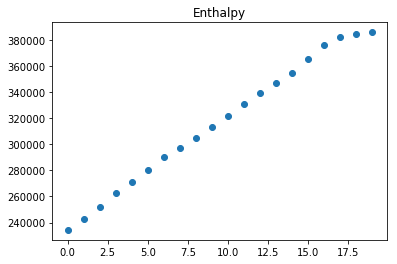

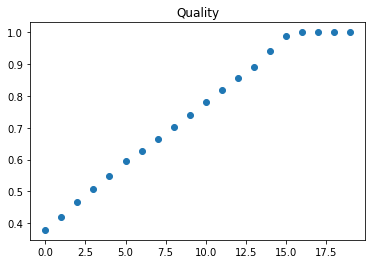

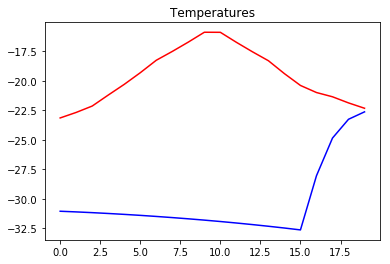

In [14]:
Ta_plot = np.ones((20))
for i in range(10):
    for j in range(2):
        
        Ta_plot[int(j_circuit[i,j])] = Ta_out[i,j]

#plt.plot(Pr_out,'o')
#plt.title('Pressure')
#plt.show()
plt.plot(hr_in,'o')
plt.title('Enthalpy')
plt.show()
plt.plot(Qr_out,'o')
plt.title('Quality')
plt.show()
plt.plot(Ta_plot-273.15,'r')
plt.plot(Tref_out-273.15,'b')
plt.title('Temperatures')
plt.show()

# rotina tirando media do ar in

In [7]:
####################
### Main Routine ###
####################

tube_it=1000000000
air_it=10000000000
cycle_it=100000000
dry_it = 100000000

alpha_tube_nodryout = 0
alpha_air = 0
alpha_cycle = 0
alpha_dry = 0

Tol_cycle = 1e-4
Tol_air = 1e-2
Tol_tube = 1e-2
tol_dryout = 1e-2

n_dry = 5

T_air_row =[0,0]

for res in range(cycle_it):
    
    hr_out_cycle_old = np.copy(hr_out)
    Pr_out_cycle_old = np.copy(Pr_out)
    Ta_out_cycle_old = np.copy(Ta_out)
    

    ############
    ### Tube ###
    ############
    
    for ind in range(20):

        ind_j,ind_k = j_index(ind,j_circuit)
        Ta_in_tube = (Ta_in[int(ind_j),[0]]+Ta_in[int(ind_j),[1]])/2
        Ta_out_tube = (Ta_out_cycle_old[int(ind_j),0]+Ta_out_cycle_old[int(ind_j),0])/2
        Ta_avg = (Ta_in_tube+Ta_out_tube)/2 
        Tr_in = prop('T','P',Pr_in[ind],'H',hr_in[ind],'R134a')        
        Q_in = abs(prop('Q','P',Pr_in[ind],'H',hr_in[ind],'R134a'))
        #Q_out = abs(prop('Q','P',Pr_out_cycle_old[ind],'H',hr_out_cycle_old[ind],'R134a'))
        Pr_out_old_it = float(np.copy(Pr_out_cycle_old[ind]))
        hr_out_old_it = float(np.copy(hr_out_cycle_old[ind]))
        Q_out = abs(prop('Q','P',Pr_out_old_it,'H',hr_out_old_it,'R134a'))

        for res in range(tube_it):
            
            Pr_out_old = Pr_out_old_it
            hr_out_old = hr_out_old_it
            Pr_avg = (Pr_in[ind]+Pr_out_old)/2
            hr_avg = (hr_in[ind]+hr_out_old)/2
            Q_avg = (Q_in+Q_out)/2

            rho_r = prop('D','P',Pr_in[ind],'H',hr_in[ind],'R134a')
            v_r = 1/rho_r
            
            if Q_in < 1 and Q_out < 1 :
                mu_r = prop('V','P',Pr_in[ind],'Q',0,'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_bi(hr_in[ind],Pr_in[ind],Pr_in[ind],Q_in,mfrr_inlet,Ta_in_tube,Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l,D_o)
                alpha_tube=alpha_tube_nodryout

            
            elif Q_in == 1 and Q_out ==1 : 
                mu_r = prop('V','P',Pr_in[ind],'H',hr_in[ind],'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_mono(hr_in[ind],Pr_in[ind],Pr_in[ind],hr_in[ind],mfrr_inlet,Ta_in_tube,Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l,D_o)
                alpha_tube=alpha_tube_nodryout

                
            elif Q_in < 1 and Q_out == 1:
                
                
                hr_in_dry = hr_in[ind]
                #hr_out_dry = hr_out_old
                Pr_in_dry = Pr_in[ind]
                #Pr_out_dry = Pr_out_old
                Q_ht_temp = 0
                F_bi = 0+1/n_dry
                
                for ind_dry in range(n_dry):
                    
                    Q_in_dry = abs(prop('Q','P',Pr_in_dry,'H',hr_in_dry,'R134a'))
                    
                    if Q_in_dry < 1:
                        mu_r = prop('V','P',Pr_in_dry,'Q',0,'R134a')
                        Pr_out_dry = movimento(Pr_in_dry,W/n_dry,D_i,G_r,v_r,mu_r)
                        hr_out_dry,Q_ht_r_dry = energia_bi(hr_in_dry,Pr_in_dry,Pr_in_dry,Q_in_dry,mfrr_inlet,Ta_in_tube,Ta_avg,Pa_inlet,mfra_inlet/(2*n_dry),W/n_dry,D_i,Ac[ind_j,ind_k]/n_dry,Ap[ind_j,ind_k]/n_dry,As[ind_j,ind_k]/n_dry,At[ind_j,ind_k]/n_dry,delta_f,k_al,x_t,x_l,D_o)
                        F_bi += 1/n_dry
                        
                    elif Q_in_dry == 1: 
                        mu_r = prop('V','P',Pr_in_dry,'H',hr_in_dry,'R134a')
                        Pr_out_dry = movimento(Pr_in_dry,W/n_dry,D_i,G_r,v_r,mu_r)
                        hr_out_dry,Q_ht_r_dry = energia_mono(hr_in_dry,Pr_in_dry,Pr_in_dry,hr_in_dry,mfrr_inlet,Ta_in_tube,Ta_avg,Pa_inlet,mfra_inlet/(2*n_dry),W/n_dry,D_i,Ac[ind_j,ind_k]/n_dry,Ap[ind_j,ind_k]/n_dry,As[ind_j,ind_k]/n_dry,At[ind_j,ind_k]/n_dry,delta_f,k_al,x_t,x_l,D_o)
                    
                    Q_ht_temp += Q_ht_r_dry
                    hr_in_dry = hr_out_dry
                    Pr_in_dry = Pr_out_dry
                    hr_out_new = hr_out_dry
                    Pr_out_new = Pr_out_dry
                    
                    
                Q_ht_r[ind] = Q_ht_temp
                alpha_tube = alpha_dry
            
                #print(F_bi)                
                                        
            Pr_out_old_it = alpha_tube*Pr_out_old + (1-alpha_tube)*Pr_out_new
            hr_out_old_it = alpha_tube*hr_out_old + (1-alpha_tube)*hr_out_new
            #Q_out = abs(prop('Q','P',Pr_out_new,'H',hr_out_new,'R134a'))
            
            res_P_tube = abs(Pr_out_new - Pr_out_old)
            res_h_tube = abs(hr_out_new - hr_out_old)
            
            res_tube =max(res_h_tube,res_P_tube)
            #print(res_tube)
            

            if res_tube < Tol_tube:
                
                break
            
            else:
                  
                continue
            
        Pr_out_cycle_new[ind]= Pr_out_new
        hr_out_cycle_new[ind]= hr_out_new

    ###########
    ### Air ###
    ###########
    
    for ind2 in range(10):
        
        Ta_in_air = (Ta_in[ind2,[0]]+Ta_in[ind2,[1]])/2
        #Ta_out_old_it = (Ta_out_cycle_old[ind2,0]+Ta_out_cycle_old[ind2,1])/2
        #Ta_avg_air = (Ta_in_air+Ta_out_air)/2 
        
        for ind5 in range(2):
            
            tube_index = j_circuit[ind2,ind5]
            Ta_out_old_it = Ta_out_cycle_old[ind2,ind5]
                             
            for res in range(air_it):

                Ta_out_old = Ta_out_old_it
                Tair_avg = (Ta_in_air+Ta_out_old)/2
                Q_ht_air = Q_ht_r[int(tube_index)] 
                Ta_out_new = energia_ar(Ta_in_air,Tair_avg,Pa_inlet,mfra_inlet/2,Q_ht_air)

                Ta_out_old_it = alpha_air*Ta_out_old + (1-alpha_air)*Ta_out_new
                res_air = abs(Ta_out_new - Ta_out_old)
                #print(res_air) 

                if res_air < Tol_air:

                    break

                else:

                    continue

            Ta_out_cycle_new[ind2,ind5] = Ta_out_new
                  
    ###############################################        
    ### Cycle convergency  and sub-relaxatation ###
    ###############################################
    
    res_P_cycle = max(abs(Pr_out_cycle_new - Pr_out_cycle_old))
    res_h_cycle = max(abs(hr_out_cycle_new - hr_out_cycle_old))
    res_ta_cycle_array = abs(Ta_out_cycle_new - Ta_out_cycle_old) 
    res_Ta_cycle = res_ta_cycle_array.max()
    res_cycle=max(res_h_cycle,res_P_cycle,res_Ta_cycle)
    print(res_cycle)
    
    if res_cycle < Tol_cycle:

        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_new[ind3]
            Pr_out[ind3] = Pr_out_cycle_new[ind3]

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):
            
            for ind6 in range(2):

                Ta_out[ind4,ind6] = Ta_out_cycle_new[ind4,ind6]

                if ind4 != 9:

                    Ta_in[ind4+1,ind6]= (Ta_out[ind4,0]+Ta_out[ind4,1])/2
                
        break
    
    else:
        
        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_old[ind3]*alpha_cycle + hr_out_cycle_new[ind3]*(1-alpha_cycle) 
            Pr_out[ind3] = Pr_out_cycle_old[ind3]*alpha_cycle + Pr_out_cycle_new[ind3]*(1-alpha_cycle)

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):
            
            for ind6 in range(2):

                Ta_out[ind4,ind6] = Ta_out_cycle_old[ind4,ind6]*alpha_cycle + Ta_out_cycle_new[ind4,ind6]*(1-alpha_cycle)

                if ind4 != 9:

                    Ta_in[ind4+1,ind6]= (Ta_out[ind4,0]+Ta_out[ind4,1])/2
            
        continue
    
    
for index in range(20):
    
    Qr_out[index] = abs(prop('Q','P',Pr_out[index],'H',hr_out[index],'R134a'))
    Qr_in[index] = abs(prop('Q','P',Pr_in[index],'H',hr_in[index],'R134a'))
    Tref_out[index] = prop('T','P',Pr_out[index],'H',hr_out[index],'R134a')
    Tref_in[index] = prop('T','P',Pr_in[index],'H',hr_in[index],'R134a')


8277.54294103
7609.13921818
10767.4507462
13776.6626069
17017.8410409
19287.1468946
20890.463186
22411.1710373
23492.6870392
25781.0802315
27798.3303583
10115.7084854
4511.56245496
4479.61553563
4497.35515652
4390.39799128
4390.9906503
4464.35725932
4404.50712559
4442.08863273
4483.44848749
4458.20337284
4486.2331611
4516.46839848
4560.11298552
4437.72866834
4014.0797281
3394.18003741
1060.53844898
623.176382127
392.525573053
356.870371112
357.580715617
358.165234842
358.880879363
359.729974848
360.722549667
361.859585338
363.093592887
364.441491626
365.921395954
368.388212307
371.072836217
340.399227543
290.302762975
228.551407126
162.72023753
106.936332261
60.1768174808
586.601827051
320.687386923
174.574773591
95.5639422515
34.967983191
35.0179746177
35.0795572884
35.15451627
35.2462298723
35.3520279256
35.4676548667
35.5948438311
35.7348809668
35.9684580587
36.2226751601
31.6649838645
20.1381327857
14.4097675383
9.16184656386
5.1770675123
5.21425771352
3.31596297363
2.12328947522
2